In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Download resources
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
# Load datasets
train_df = pd.read_parquet(r"C:\Users\asus\Desktop\ESG green washing detection\train-00000-of-00001-98aa5228a06a17d0.parquet")
valid_df = pd.read_parquet(r"C:\Users\asus\Desktop\ESG green washing detection\validation-00000-of-00001-2553e47d408fab28.parquet")
test_df = pd.read_parquet(r"C:\Users\asus\Desktop\ESG green washing detection\test-00000-of-00001-79fd931297fff765.parquet")

esg_docs_df = pd.read_csv(
    r"C:\Users\asus\Desktop\ESG green washing detection\datasets\esg_documents_for_dax_companies.csv",
    sep="|", engine="python", quoting=3, on_bad_lines="skip"
)

In [9]:
# Merge and shuffle
df = pd.concat([train_df, valid_df, test_df], axis=0)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
# POS tagging helper for lemmatizer
def get_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN


lemmatizer = WordNetLemmatizer()

In [11]:
# Improved cleaning with lemmatization
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    words = word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    
    lemmatized = [lemmatizer.lemmatize(w, get_pos(t)) for w, t in pos_tags]
    return " ".join(lemmatized)


df["clean_text"] = df["text"].apply(clean_text)

In [12]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2,
    random_state=42, stratify=df["label"]
)

In [13]:
# Better TF-IDF (bi-grams help catch ESG "buzz phrases")
vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words="english",
    ngram_range=(1, 2)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [17]:
# Hyperparameter Tuning for Logistic Regression
params = {"C": [0.1, 1, 2, 5]}
grid = GridSearchCV(
    LogisticRegression(max_iter=300, class_weight="balanced"),
    param_grid=params, scoring="f1", cv=3, n_jobs=-1
)
grid.fit(X_train_vec, y_train)

model = grid.best_estimator_
print("\nBest C Value:", grid.best_params_)


Best C Value: {'C': 2}


In [18]:
# Evaluation
y_pred = model.predict(X_test_vec)
y_prob = model.predict_proba(X_test_vec)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       397
           1       0.68      0.83      0.75       133

    accuracy                           0.86       530
   macro avg       0.81      0.85      0.82       530
weighted avg       0.87      0.86      0.86       530

Accuracy: 0.8584905660377359
F1 Score: 0.7474747474747475
ROC-AUC: 0.9342626086627147


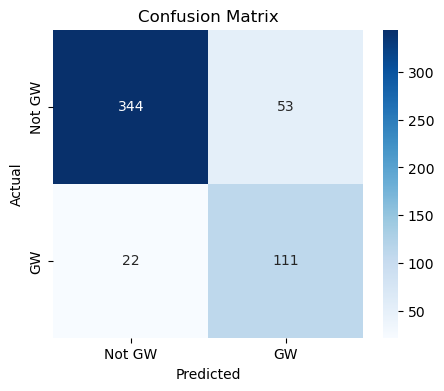

In [19]:
# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not GW", "GW"],
            yticklabels=["Not GW", "GW"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
# Predict New ESG Documents
esg_docs_df["clean_content"] = esg_docs_df["content"].apply(clean_text)
X_esg_vec = vectorizer.transform(esg_docs_df["clean_content"])
esg_docs_df["predicted_label"] = model.predict(X_esg_vec)
esg_docs_df["greenwashing_probability"] = model.predict_proba(X_esg_vec)[:, 1]

print("\nSample Predictions:")
print(esg_docs_df[["company", "title", "predicted_label", "greenwashing_probability"]].head(10))
# 0=No greenwashing; 1=potential greenwashing


Sample Predictions:
            company                                            title  \
0     Beiersdorf AG          BeiersdorfAG Sustainability Report 2021   
1            Qiagen            QiagenN.V. Sustainability Report 2020   
2        Daimler AG                      unknown Annual Report Store   
3            E ONSE                E.ONSE Sustainability Report 2020   
4            Henkel       HenkelAG&CoKGaA Sustainability Report p.DE   
5  Deutsche Bank AG                DeutscheBankAG Annual Report 2020   
6        Vonovia SE             VonoviaSE Sustainability Report 2020   
7    Siemens Energy         SiemensEnergy Sustainability Report 2020   
8            Qiagen            QiagenN.V. Sustainability Report 2021   
9         Fresenius  FreseniusMedicalCare Sustainability Report 2020   

   predicted_label  greenwashing_probability  
0                1                  0.993708  
1                1                  0.998997  
2                0                  0.237948 

In [12]:
# Save model for reuse
import joblib
joblib.dump(model, "greenwashing_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("\nModel & Vectorizer Saved!")



Model & Vectorizer Saved!


In [1]:
import pandas as pd

df = pd.read_parquet(r"C:\Users\asus\Desktop\ESG green washing detection\train-00000-of-00001-98aa5228a06a17d0.parquet")
print(df.columns.tolist())


['text', 'label']


In [2]:
import pandas as pd

df = pd.read_csv(
    r"esg_documents_for_dax_companies.csv",
    on_bad_lines="skip", engine="python"
)

print(df.columns.tolist())

['|company|content|datatype|date|domain|esg_topics|internal|symbol|title|url']


NameError: name 'python' is not defined